In [4]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

In [5]:
class DigitDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype('float32')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitDataset("./dataset/train.csv", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DigitClassifier()

In [15]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        writer.add_scalar("Loss/train", running_loss / len(loader), epoch)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.4f}')

train(model, train_loader, criterion, optimizer)


Epoch [1/5], Loss: 0.0362
Epoch [2/5], Loss: 0.0267
Epoch [3/5], Loss: 0.0228
Epoch [4/5], Loss: 0.0179
Epoch [5/5], Loss: 0.0176


In [16]:
def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / len(loader.dataset):.2f}%')

test(model, test_loader)


Accuracy: 98.25%


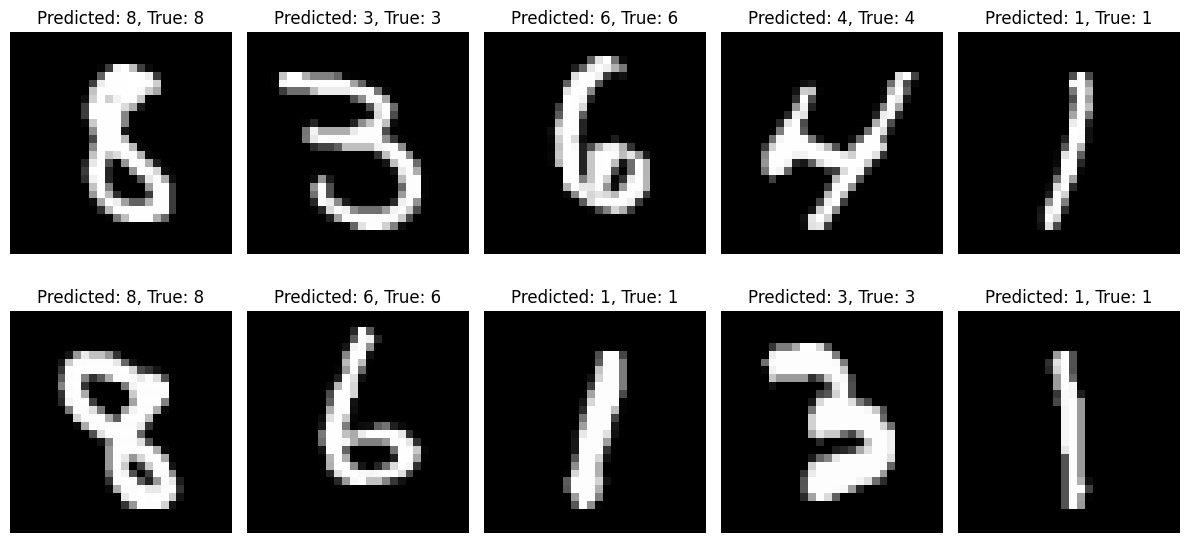

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

def show_random_predictions(model, test_loader):
    model.eval()  
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    
    indices = random.sample(range(len(images)), 10)
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        image = images[idx]
        label = labels[idx]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0))
        
        _, predicted = torch.max(output, 1)

        plt.subplot(2, 5, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f'Predicted: {predicted.item()}, True: {label.item()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_predictions(model, test_loader)
